In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [4]:
import os 
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import Kan_NN
import importlib
importlib.reload(Kan_NN)

<module 'Kan_NN' from 'c:\\Users\\JP\\Documents\\TU Berlin\\Master\\Code_clean\\Kan_NN.py'>

In [5]:
#### FRIEDMANN 1
from sklearn.datasets import make_friedman1
def get_loader(in_dim, noise, n_samples = 20000):
    # Set the seed for reproducibility
    seed = 42
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Generate the Friedmann dataset
    X_train, y = make_friedman1(n_samples=int(n_samples * 0.8), n_features= in_dim, random_state=seed, noise=noise)
    y_train = np.expand_dims(y, axis=1)
    # Split into train and test sets (80% train, 20% test)
    X_test, y = make_friedman1(n_samples=int(n_samples * 0.2), n_features= in_dim, random_state=seed, noise=0.0)
    y_test = np.expand_dims(y, axis=1)
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create TensorDataset for train and test sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Set batch size and create DataLoader for training and testing
    batch_size = 1024
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    return train_loader, test_loader



In [6]:
@torch.no_grad()
def compute_test_loss(test_loader, model):
    criterion = torch.nn.MSELoss()
    running_loss = 0.
    for batch, target in test_loader:
        outputs = model(batch)
        loss = criterion(target, outputs)
        running_loss += loss.item()
    return running_loss / len(test_loader)

5 0.0 [32]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [1/1], Loss: 233.554560, test: 228.176947, lr: 0.001000


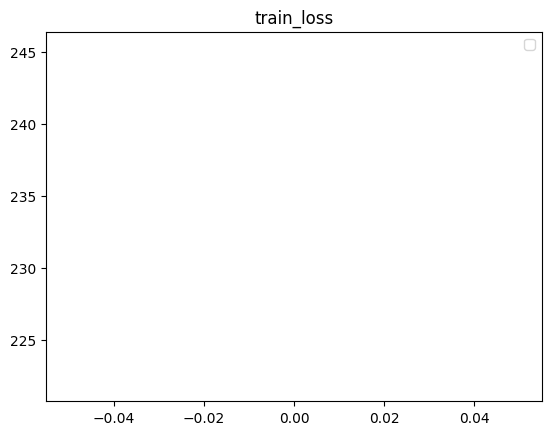

Training Complete!
5 1.0 [32]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [1/1], Loss: 234.449774, test: 228.176437, lr: 0.001000


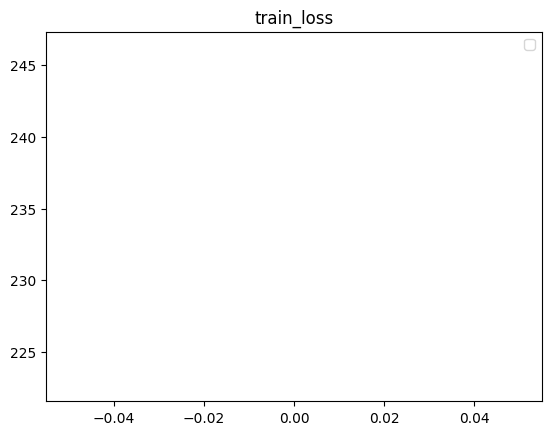

Training Complete!
100 0.0 [32]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [1/1], Loss: 225.838176, test: 217.671948, lr: 0.001000


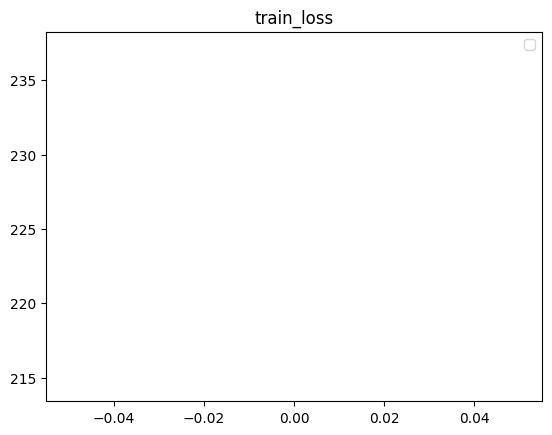

Training Complete!
100 1.0 [32]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [1/1], Loss: 226.791016, test: 217.671479, lr: 0.001000


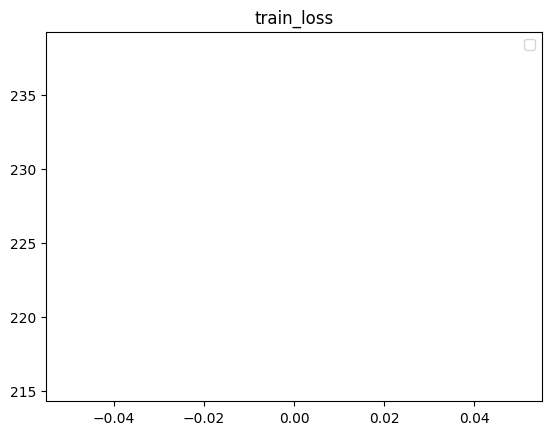

Training Complete!


In [ ]:
import time
import dill
adjust = True 
epochs = 1000
widths = [[32]]
n_samples = 20000
in_dims = [5,100]
noises = [0.,1.]
train_losses = []
test_losses = []
for width in widths:
    for in_dim in in_dims:
        for noise in noises:
            print(in_dim, noise, width)
            train_loader, test_loader = get_loader(in_dim, noise,n_samples)
            shape = [in_dim, 6,2,1]
            model = Kan_NN.Neural_Kan(shape = shape, h = width)
            model.train()
            optimizer = optim.AdamW(model.parameters(), lr=0.001)
            criterion = torch.nn.MSELoss()
            for epoch in range(epochs):
                running_loss = 0.0 
                for batch, target in train_loader:
                    start_time = time.time()
                    optimizer.zero_grad()
                    outputs = model(batch)
                    loss = criterion(target, outputs)
                    loss.backward()
                    if not adjust:
                        torch.nn.utils.clip_grad_norm(model.parameters(), max_norm = 1)
                    optimizer.step()
                    running_loss += loss.item()
                avg_loss = running_loss / len(train_loader)
                model.train_loss.append(avg_loss)
                test_l = compute_test_loss(test_loader, model)
                model.test_loss.append(test_l)
                if (test_l < 1) and (adjust):
                    adjust = False
                #    for param_group in optimizer.param_groups:
                #        param_group['lr'] *= 0.1

                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}, test: {test_l:.6f}, lr: {optimizer.param_groups[0]['lr']:6f}")
            plt.plot(model.train_loss[-50:])
            plt.title(f'train_loss')
            plt.legend()
            plt.show()
            print("Training Complete!")
            with open(f"models/Friedmann_1_KAN_{width[0]}_{noise}_{in_dim}.dill", "wb") as f:
                dill.dump(model, f)
            #with open(f"models/KAN_{width[0]}_{noise}_{in_dim}.dill", "wb") as f:
            #    dill.dump(model, f)

